<a href="https://colab.research.google.com/github/tashir0605/SentimentSphere/blob/main/Emotion%20Through%20Text/Human_Emotion_via_text_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Text Emotion Detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
CKPT_DIR = '/content/drive/MyDrive/colab_checkpoints'



Mounted at /content/drive


In [2]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()


!pip install lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a83012c967ffc8cf68fbaef09560283dbd9bdd0b4bfb3b2dd70c38572c0ec31c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

**Dataset**

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
dfs = pd.read_csv(
    "text_emotion_dataset_raw.csv"

)

In [5]:
assert len(dfs) >= 8000, "Dataset should have at least 8000 rows for test and validation sets."

In [6]:
# First, split into train+val and test
train_val, df_test = train_test_split(dfs, test_size=0.2, random_state=42, stratify=dfs['Emotion'])

# Now split train_val into train and validation
df_train, df_val = train_test_split(train_val, test_size=0.2, random_state=42, stratify=train_val['Emotion'])


In [7]:
# Verify the sizes
print(f"Training set: {len(df_train)} rows")
print(f"Test set: {len(df_test)} rows")
print(f"Validation set: {len(df_val)} rows")

Training set: 22266 rows
Test set: 6959 rows
Validation set: 5567 rows


In [8]:

# Save the split datasets if needed
df_train.to_csv("df_train.csv", index=False)
df_test.to_csv("df_test.csv", index=False)
df_val.to_csv("df_val.csv", index=False)

In [9]:
df_train.head()

,Emotion,Text
11065,sadness,Last day off until five days straight of work.
21314,fear,Walking alone in the dark in a strange street.
15500,joy,I most joyous moment was the day I got my mark...
6665,joy,Most estate agents were overjoyed at the elect...
19365,sadness,@Hillmonious sounds solid :p that's a good mov...


In [10]:
#print the shape of the data set
print(df_train.shape)

(22266, 2)


In [11]:
#print first 5 rows
df_test.head()

,Emotion,Text
32781,fear,I'm now scared of small light green leafs bc t...
7349,sadness,been home for the past 45 min and iv been work...
24551,sadness,"Forgive and forget, gets the best of me, I car..."
8167,joy,Hahaha tomorrow my day is about to be wasted i...
26427,joy,"“Sometimes your is the source of your smile, b..."


In [12]:
#print the shape of the data set
print(df_test.shape)

(6959, 2)


In [13]:
#print first 5 rows
df_val.head()

,Emotion,Text
19409,disgust,Don't come back to me w that shit ever again.....
31962,sadness,"@csilcox32 yah it got knocked down, so my duty..."
7412,surprise,lovely birthday meal with all everyone! So muc...
5487,sadness,General Ye Jianying died.
26679,joy,@chibchenko i'll just keep it aw for myself th...


In [14]:
#print the shape of the data set
print(df_val.shape)

(5567, 2)


In [15]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

,count
Emotion,
joy,7069
sadness,4301
fear,3462
anger,2750
surprise,2600
neutral,1442
disgust,548
shame,94


In [16]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

,count
Emotion,
joy,31.747957
sadness,19.316447
fear,15.548370
anger,12.350669
surprise,11.676996
neutral,6.476242
disgust,2.461152
shame,0.422168


<Axes: xlabel='Emotion', ylabel='count'>

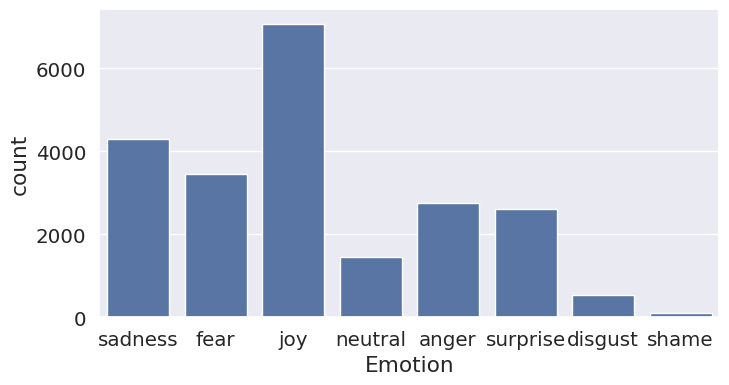

In [17]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion',data=df_train)


The provided dataset exhibits class imbalance, with certain emotion categories being more prevalent than others. While there is a possibility to address this imbalance through various techniques, it is noteworthy that the emotions of primary interest are already among the most frequently occurring. Consequently, it is currently deemed acceptable to retain the dataset in its original form, without undertaking explicit measures to rebalance the class distribution.The data is imbalanced so, we may try to balance it but also, the emotions that we interested in are the most repeated emotion so, till now we can keep the data as it is

In [18]:
#print the number of null values in each column
df_train.isnull().sum()

,0
Emotion,0
Text,0


In [19]:
#print the number of duplicated values
df_train.duplicated().sum()

np.int64(1662)

In [20]:
#removing duplicated values having Same text + Same emotion
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [21]:
df_train.shape

(20604, 2)

There is just 2301 row which is duplicated but we need to check also if there are rows having the same text but different emotions

In [22]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Emotion,Text
4881,neutral,Wow !
5445,joy,Thank you .
6005,sadness,It's us .
6288,joy,Thanks .
6637,joy,OK .
7033,joy,Yes .
7134,joy,It sure is .
8324,joy,Bye .
9788,anger,Why not ?
9805,joy,You bet !


In [23]:
# Step 1: Identify texts with conflicting emotion labels
conflicting_texts = df_train.groupby("Text")["Emotion"].nunique()
conflicting_texts = conflicting_texts[conflicting_texts > 1].index  # Texts with >1 unique emotion

# Step 2: Keep most frequent emotion for conflicting texts (majority voting)
def keep_majority_emotion(group):
    """Keep only the most frequent emotion for each text"""
    return group[group['Emotion'] == group['Emotion'].mode()[0]].head(1)

# Apply majority voting only to conflicting texts
conflicting_data = df_train[df_train["Text"].isin(conflicting_texts)]
resolved_conflicts = conflicting_data.groupby("Text", group_keys=False).apply(keep_majority_emotion)

# Combine resolved conflicts with non-conflicting data
non_conflicting = df_train[~df_train["Text"].isin(conflicting_texts)]
df_train = pd.concat([non_conflicting, resolved_conflicts], ignore_index=True)

# Step 3: Drop exact duplicates (same text & emotion)
df_train = df_train.drop_duplicates()

# Step 4: Print the shape after cleanup
print(df_train.shape)
print(f"Resolved {len(conflicting_texts)} conflicting texts using majority voting")


(20572, 2)
Resolved 30 conflicting texts using majority voting


/tmp/ipython-input-4161788845.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resolved_conflicts = conflicting_data.groupby("Text", group_keys=False).apply(keep_majority_emotion)


In [24]:
print(df_train["Text"].duplicated().sum())  # Should be 0 if all duplicates were removed


0


In [25]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

,count
stop_words,
4,2460
5,2344
3,2308
6,2096
2,2077
7,1736
0,1566
1,1541
8,1348


The data contains alot of stopwords (some rows contains more than 25 stopword!) so, we need to take care when we remove them as some rows may become empty

In [26]:
# Remove 'shame' emotion from all datasets
print("="*50)
print("REMOVING SHAME EMOTION FROM ALL SPLITS")
print("="*50)

# Check counts before removal
print("\nBefore removal:")
print(f"Train - Shame count: {(df_train['Emotion'] == 'shame').sum()}")
print(f"Val - Shame count: {(df_val['Emotion'] == 'shame').sum()}")
print(f"Test - Shame count: {(df_test['Emotion'] == 'shame').sum()}")
print(f"Total shame samples: {(df_train['Emotion'] == 'shame').sum() + (df_val['Emotion'] == 'shame').sum() + (df_test['Emotion'] == 'shame').sum()}")

print(f"\nOriginal sizes:")
print(f"Train: {df_train.shape[0]}, Val: {df_val.shape[0]}, Test: {df_test.shape[0]}")

REMOVING SHAME EMOTION FROM ALL SPLITS

Before removal:
Train - Shame count: 93
Val - Shame count: 23
Test - Shame count: 29
Total shame samples: 145

Original sizes:
Train: 20572, Val: 5567, Test: 6959


In [27]:
# Remove shame from all splits
df_train = df_train[df_train['Emotion'] != 'shame'].copy()
df_val = df_val[df_val['Emotion'] != 'shame'].copy()
df_test = df_test[df_test['Emotion'] != 'shame'].copy()

# Reset indices
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [28]:
# Check after removal
print(f"\nAfter removal:")
print(f"Train: {df_train.shape[0]}, Val: {df_val.shape[0]}, Test: {df_test.shape[0]}")

print(f"\nRemaining emotion classes ({len(df_train['Emotion'].unique())}):")
print(sorted(df_train['Emotion'].unique()))

print(f"\nNew class distribution in training set:")
print(df_train['Emotion'].value_counts())
print(f"\nPercentages:")
print((df_train['Emotion'].value_counts() / len(df_train) * 100).round(2))

print("\n✅ Shame emotion successfully removed from all datasets!")


After removal:
Train: 20479, Val: 5544, Test: 6930

Remaining emotion classes (7):
['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

New class distribution in training set:
Emotion
joy         6830
sadness     4068
fear        2939
surprise    2574
anger       2536
neutral      984
disgust      548
Name: count, dtype: int64

Percentages:
Emotion
joy         33.35
sadness     19.86
fear        14.35
surprise    12.57
anger       12.38
neutral      4.80
disgust      2.68
Name: count, dtype: float64

✅ Shame emotion successfully removed from all datasets!


<Axes: ylabel='Frequency'>

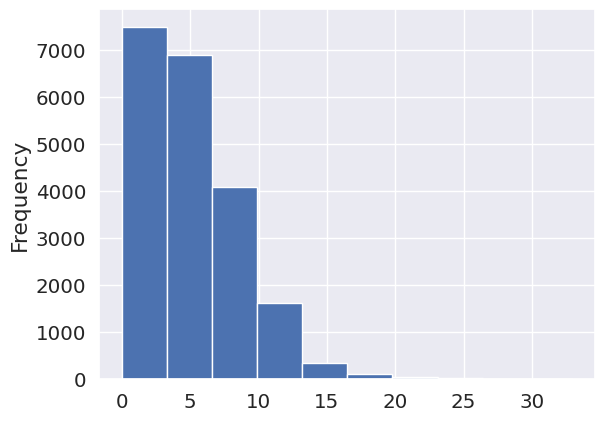

In [29]:

#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')

# Test dataset

In [30]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

,count
Emotion,
joy,2209
sadness,1345
fear,1082
anger,860
surprise,812
neutral,451
disgust,171


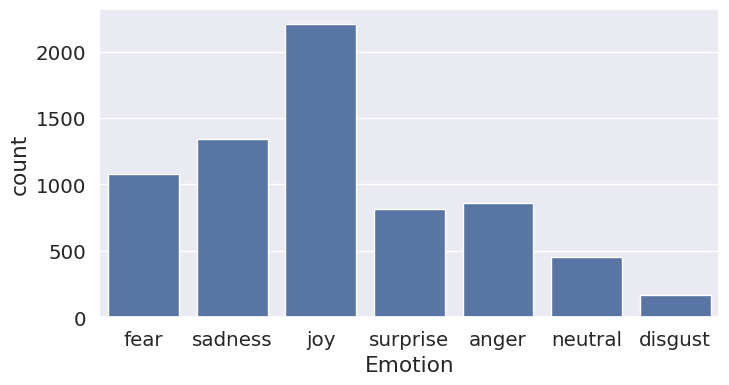

In [31]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);

In [32]:
#print the number of null values in each column
df_test.isnull().sum()

,0
Emotion,0
Text,0


In [33]:
#print the number of duplicated values
df_test.duplicated().sum()

np.int64(271)

In [34]:
#print the rows which are duplicated
df_test[df_test['Text'].duplicated() == True]

,Emotion,Text
197,neutral,Yes .
345,fear,Strictly avoid frightening ideas
435,neutral,Why not ?
436,neutral,Why not ?
585,neutral,Yes .
...,...,...
6818,sadness,"In their communiqu , the finance ministers cou..."
6889,fear,"not afraid of tomorrow, for I have seen yester..."
6895,neutral,Bye !
6915,fear,I don't need to swear to anything. Punch your ...


In [35]:
#removing duplicated values

index = df_test[df_test.duplicated() == True].index
df_test = df_test.drop_duplicates().reset_index(drop=True)



In [36]:
df_test.shape

(6659, 2)

In [37]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_test[df_test['Text'].duplicated() == True]

,Emotion,Text
1543,joy,Okay .
1565,neutral,Thanks .
2069,neutral,"Oh , no ."
2223,joy,Yes .
3169,neutral,And why are you yarning now ? Are you bored ?
5514,sadness,I don't think you really want to hear about i...
5866,anger,Certainly not .
5947,joy,OK .


In [38]:
#print some rows to check
df_test[df_test['Text'] == dfs.iloc[419]['Text']]
df_test[df_test['Text'] == dfs.iloc[729]['Text']]
df_test[df_test['Text'] == dfs.iloc[2109]['Text']]

,Emotion,Text
2306,neutral,What for ?


In [39]:
# Step 1: Identify texts with conflicting emotion labels
conflicting_texts = df_test.groupby("Text")["Emotion"].nunique()
conflicting_texts = conflicting_texts[conflicting_texts > 1].index  # Texts with >1 unique emotion

# Step 2: Keep most frequent emotion for conflicting texts (majority voting)
def keep_majority_emotion(group):
    """Keep only the most frequent emotion for each text"""
    return group[group['Emotion'] == group['Emotion'].mode()[0]].head(1)

# Apply majority voting only to conflicting texts
conflicting_data = df_test[df_test["Text"].isin(conflicting_texts)]
resolved_conflicts = conflicting_data.groupby("Text", group_keys=False).apply(keep_majority_emotion)

# Combine resolved conflicts with non-conflicting data
non_conflicting = df_test[~df_test["Text"].isin(conflicting_texts)]
df_test = pd.concat([non_conflicting, resolved_conflicts], ignore_index=True)

# Step 3: Drop exact duplicates (same text & emotion)
df_test = df_test.drop_duplicates()

# Step 4: Print the shape after cleanup
print(df_test.shape)
print(f"Resolved {len(conflicting_texts)} conflicting texts using majority voting")

(6651, 2)
Resolved 8 conflicting texts using majority voting


/tmp/ipython-input-2330045196.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resolved_conflicts = conflicting_data.groupby("Text", group_keys=False).apply(keep_majority_emotion)


In [40]:
print(df_train["Text"].duplicated().sum())  # Should be 0 if all duplicates were removed

0


In [41]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

,count
stop_words,
4,767
5,766
3,714
2,663
6,653
7,561
0,530
1,497
8,468


<Axes: ylabel='Frequency'>

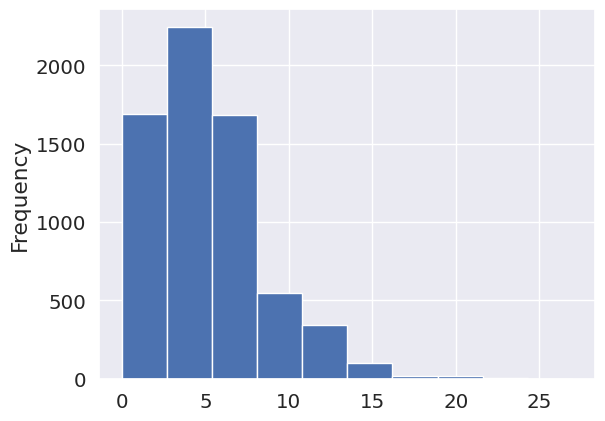

In [42]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

# Validation Dataset

In [43]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

,count
Emotion,
joy,1767
sadness,1076
fear,866
anger,687
surprise,650
neutral,361
disgust,137


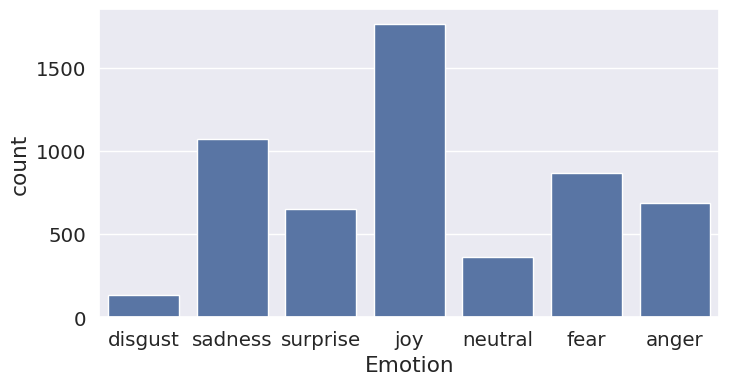

In [44]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [45]:
#print the number of null values in each column
df_val.isnull().sum()

,0
Emotion,0
Text,0


In [46]:
#print the number of duplicated values
df_val.duplicated().sum()

np.int64(206)

In [47]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Emotion,Text
143,neutral,Yes .
240,neutral,Yes .
258,fear,"For Swift , there is a connection between cosm..."
305,neutral,Well ...
383,fear,"not afraid of tomorrow, for I have seen yester..."
...,...,...
5465,neutral,Why not ?
5482,neutral,And ?
5507,fear,You gain and confidence by every experience ...
5518,fear,Strictly avoid frightening ideas


In [48]:
#removing duplicated values
index = df_val[df_val.duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [49]:
df_val.shape

(5338, 2)

In [50]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_val[df_val['Text'].duplicated() == True]

,Emotion,Text
1359,neutral,You ’ re right .
3595,neutral,Thank you .
3780,joy,Thank you very much .
5138,anger,Not at all .


In [51]:
# Step 1: Identify texts with conflicting emotion labels
conflicting_texts = df_val.groupby("Text")["Emotion"].nunique()
conflicting_texts = conflicting_texts[conflicting_texts > 1].index  # Texts with >1 unique emotion

# Step 2: Keep most frequent emotion for conflicting texts (majority voting)
def keep_majority_emotion(group):
    """Keep only the most frequent emotion for each text"""
    return group[group['Emotion'] == group['Emotion'].mode()[0]].head(1)

# Apply majority voting only to conflicting texts
conflicting_data = df_val[df_val["Text"].isin(conflicting_texts)]
resolved_conflicts = conflicting_data.groupby("Text", group_keys=False).apply(keep_majority_emotion)

# Combine resolved conflicts with non-conflicting data
non_conflicting = df_val[~df_val["Text"].isin(conflicting_texts)]
df_val = pd.concat([non_conflicting, resolved_conflicts], ignore_index=True)

# Step 3: Drop exact duplicates (same text & emotion)
df_val = df_val.drop_duplicates()

# Step 4: Print the shape after cleanup
print(df_val.shape)
print(f"Resolved {len(conflicting_texts)} conflicting texts using majority voting")

(5334, 2)
Resolved 4 conflicting texts using majority voting


/tmp/ipython-input-3370190907.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resolved_conflicts = conflicting_data.groupby("Text", group_keys=False).apply(keep_majority_emotion)


In [52]:
print(df_val["Text"].duplicated().sum())  # Should be 0 if all duplicates were removed

0


In [53]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]

,count
stop_words,
4,673
5,621
3,568
2,562
6,508
1,440
0,426
7,424
8,333


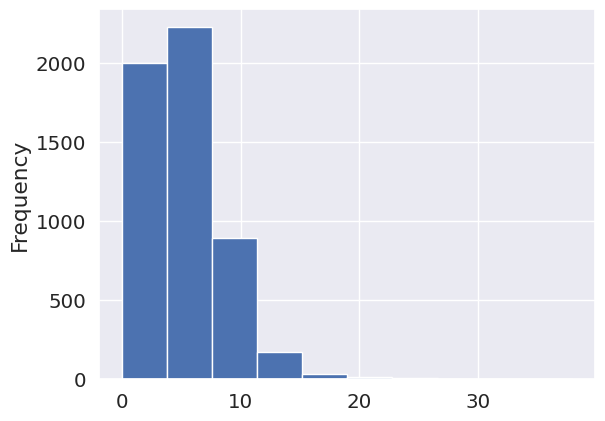

In [54]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

# Compare rows of the datasets

Check that there is no data leakage

In [55]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Use NLTK's stopword list
stop_words = set(stopwords.words('english'))

def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    comparison_df = df1.merge(df2, indicator=True, how='outer')
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    return diff_df

# Preprocessing functions
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_stop_words(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def Removing_numbers(text):
    return ''.join([char for char in text if not char.isdigit()])

def lower_case(text):
    return " ".join([word.lower() for word in text.split()])

def Removing_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_{|}~"""), ' ', text)
    text = text.replace('؛', '')
    text = re.sub('\s+', ' ', text)
    return text.strip()

def Removing_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_small_sentences(df):
    df['Text'] = df['Text'].apply(lambda x: np.nan if len(str(x).split()) < 3 else x)
    df.dropna(subset=['Text'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def normalize_text(df):
    df['Text'] = df['Text'].apply(lower_case)
    df['Text'] = df['Text'].apply(remove_stop_words)
    df['Text'] = df['Text'].apply(Removing_numbers)
    df['Text'] = df['Text'].apply(Removing_punctuations)
    df['Text'] = df['Text'].apply(Removing_urls)
    df['Text'] = df['Text'].apply(lemmatization)
    df = remove_small_sentences(df)
    df.reset_index(drop=True, inplace=True)
    return df

def normalized_sentence(sentence):
    sentence = lower_case(sentence)
    sentence = remove_stop_words(sentence)
    sentence = Removing_numbers(sentence)
    sentence = Removing_punctuations(sentence)
    sentence = Removing_urls(sentence)
    sentence = lemmatization(sentence)
    return sentence

# Example test sentence
print(normalized_sentence("My Name is _Maysaa. @Tweets,  "))

# Normalize the datasets
df_train = normalize_text(df_train)
df_test = normalize_text(df_test)
df_val = normalize_text(df_val)

# Remove overlaps to ensure clean splits
df_test = df_test[~df_test['Text'].isin(df_train['Text'])]
df_val = df_val[~df_val['Text'].isin(df_train['Text'])]
df_val = df_val[~df_val['Text'].isin(df_test['Text'])]

# Reset index after filtering
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

# Assert no data leakage between datasets
assert len(set(df_train['Text']).intersection(df_test['Text'])) == 0, "Train-Test leakage detected!"
assert len(set(df_train['Text']).intersection(df_val['Text'])) == 0, "Train-Val leakage detected!"
assert len(set(df_test['Text']).intersection(df_val['Text'])) == 0, "Test-Val leakage detected!"

# Optional: Print overlaps
print("Train-Test overlap:")
print(dataframe_difference(df_train, df_test, which='both'))

print("Train-Val overlap:")
print(dataframe_difference(df_train, df_val, which='both'))

print("Val-Test overlap:")
print(dataframe_difference(df_val, df_test, which='both'))


<>:39: SyntaxWarning: invalid escape sequence '\]'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\]'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-828568445.py:39: SyntaxWarning: invalid escape sequence '\]'
  text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_{|}~"""), ' ', text)
/tmp/ipython-input-828568445.py:41: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


name maysaa tweet
Train-Test overlap:
Empty DataFrame
Columns: [Emotion, Text, _merge]
Index: []
Train-Val overlap:
Empty DataFrame
Columns: [Emotion, Text, _merge]
Index: []
Val-Test overlap:
Empty DataFrame
Columns: [Emotion, Text, _merge]
Index: []


# Cleaning

# Modeling

TF-IDF (Term Frequency - Inverse Document Frequency) is a technique used to address certain issues associated with word counts. In traditional word counts, the most frequently occurring words, including common stop words, are given significant attention despite their lack of importance.

TF-IDF adjusts these word counts by considering two factors:

1. Term Frequency (TF): This measures the frequency of a term within a specific document. It assigns higher weight to words that appear more frequently in the document.

2. Inverse Document Frequency (IDF): This measures the rarity of a term across all documents in a corpus. It assigns higher weight to words that are relatively rare across the entire collection of documents.

By combining TF and IDF, TF-IDF aims to give more importance to words that are both rare across all documents (high IDF) and appear frequently within a specific document (high TF). This approach helps highlight terms that are distinctive to a particular document.

In TF-IDF, if a word appears only in the current document or sentence, it will have a TF-IDF value of 1. If a word appears in all documents or sentences except the current one, it will have a TF-IDF value of 0. For words that are common across both the current document and all others, their TF (count) will be high, but the IDF (discount) will be even higher, resulting in a lower overall TF-IDF value.

This way, TF-IDF offers a more nuanced representation of word importance by considering both the local importance within a document (TF) and the global rarity across all documents (IDF).

**Data pre-processing**

In Natural Language Processing (NLP), **neattext** refers to a Python library designed to provides a set of simple and easy-to-use functions for cleaning, formatting, and processing text data.

**Some of the common functionalities offered by the neattext library include:**

1. Removing special characters and unwanted symbols

2. Normalization: This includes tasks like converting text to lowercase, expanding contractions (e.g., changing "I'm" to "I am"), and removing stopwords (common words like "the", "is", etc. that don’t add much meaning in NLP tasks).

3. Handling tokenization: neattext can tokenize a given sentence into words, which is useful for many downstream NLP tasks.

4. Text formatting: It provides tools for removing extra whitespaces, line breaks, and formatting issues.

In [56]:
#Preprocess text
X_train = df_train['Text']
y_train = df_train['Emotion'].values

X_test = df_test['Text']
y_test = df_test['Emotion'].values

X_val = df_val['Text']
y_val = df_val['Emotion'].values

In [57]:
def train_model(model, data, targets):

    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [58]:
def get_F1(trained_model,X,y):

    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

# Better

**Text Preprocessing**

In [59]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [60]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [61]:
#print the labels after encoding
print(set(y_train))

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}


In [62]:
# Classes: ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
# Number of classes: 7
# One-hot vector size: 7

# Example:
# 'joy' → [0, 0, 0, 1, 0, 0, 0]  (position 3)
# 'sadness' → [0, 0, 0, 0, 0, 1, 0]  (position 5)
# 'fear' → [0, 0, 1, 0, 0, 0, 0]  (position 2)



#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

**Tokenization**

### **1. `num_words=10000`**
- **Limits vocabulary to top 10,000 most frequent words**
- Words ranked by frequency: most common get indices 1-10,000
- Less frequent words beyond 10,000 are treated as unknown
- Reduces memory and prevents overfitting on rare words

In [63]:
X_train

,Text
0,last day five day straight work
1,walking alone dark strange street
2,joyous moment day got mark happy came know mar...
3,estate agent overjoyed election result
4,hillmonious sound solid p that s good movie d ...
...,...
19479,first away game parrot academy today wish v bo...
19480,great movie marathon wonderful roommate wawa c...
19481,grandfather s funeral
19482,rescued dog often somewhat nervous people yet ...


In [64]:
# Tokenize words
tokenizer = Tokenizer(num_words=15000, oov_token='UNK')
# Fit only on training data
tokenizer.fit_on_texts(X_train)


In [65]:
print(tokenizer.fit_on_texts(X_train))


None


In [66]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

38968

In [67]:
#print the index of a single word
tokenizer.word_index['towards']

732

In [68]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[39], [3], [856], [3], [981], [15]]

In [69]:
# #convert the list of indexes into a matrix of ones and zeros (BOW)
# tokenizer.texts_to_matrix(X_train[0].split())

In [70]:
# Total unique words found in your training data
vocab_size = len(tokenizer.word_index)
print(f"Total unique words in training data: {vocab_size}")

Total unique words in training data: 26186


In [71]:
#the sentence contains three words and the size of the vocabulary is 31649
tokenizer.texts_to_matrix(X_train[0].split()).shape

(6, 15000)

In [72]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

# Padding


The vectors we obtain are generally not of equal lengths


For that, we might need to pad the sequences to max len.

In [73]:
df_test.shape

# Test set has 5,651 samples with 2 columns (Text, Emotion).

(5651, 2)

In [74]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

368


Longest text in training data has 368 words.

In [75]:
X_train = pad_sequences(sequences_train, maxlen=maxlen, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=maxlen, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 26187


* Makes all sequences exactly 368 tokens long


* Shorter texts: Padded with 0s at the start
* Longer texts: Truncated from the beginning (truncating='pre')\

It's Redundant for Training Data
For Training Data:

* maxlen = 368 is the longest sequence in training
* No training sequence exceeds 368
Truncation parameter does nothing for X_train
* Only padding happens (for sequences <368)

But For Test/Val Data:

* Test/val sets might have sequences >368
* If a test text has 400 words, it gets truncated to 368
* Truncation parameter IS relevant here

In [76]:
#before
sequences_train[0]

[39, 3, 856, 3, 981, 15]

In [77]:
#after
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [78]:
print(y_train)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [79]:
y_train.shape

(19484, 7)

# Word Embedding

This code defines the following variables:

path_to_glove_file: The file path to the GloVe word vectors file.

num_tokens: The size of the vocabulary. This is typically the number of unique words in the dataset.

embedding_dim: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.) depending on the size of the word vectors file that is being used.

hits: A counter for the number of words that are found in the embeddings_index dictionary.

misses: A counter for the number of words that are not found in the embeddings_index dictionary.

embeddings_index: A dictionary that will store the word vectors, with the words as keys and the word vectors as values.

In [80]:
import os
from tqdm import tqdm

def load_glove_embeddings_improved(path_to_glove_file, tokenizer, num_tokens, embedding_dim,
                                  initialize_missing='random'):
    """
    Improved GloVe embedding loading with better error handling and options

    Parameters:
    - path_to_glove_file: path to GloVe file
    - tokenizer: fitted Keras tokenizer
    - num_tokens: vocabulary size
    - embedding_dim: embedding dimension
    - initialize_missing: 'random', 'zero', or 'normal' for missing words
    """

    print(f"Loading GloVe embeddings from: {path_to_glove_file}")

    # Check if file exists
    if not os.path.exists(path_to_glove_file):
        print(f"❌ GloVe file not found: {path_to_glove_file}")
        return create_random_embedding_matrix(num_tokens, embedding_dim), 0, 0

    # Get file size for progress bar
    file_size = os.path.getsize(path_to_glove_file)

    embeddings_index = {}
    hits = 0
    misses = 0

    # Load embeddings with progress bar and error handling
    try:
        with open(path_to_glove_file, 'r', encoding='utf-8') as f:
            with tqdm(total=file_size, unit='B', unit_scale=True, desc="Loading GloVe") as pbar:
                for line_num, line in enumerate(f, 1):
                    try:
                        parts = line.rstrip().split(' ')
                        word = parts[0]

                        # Validate embedding dimension
                        if len(parts) - 1 != embedding_dim:
                            print(f"⚠️ Line {line_num}: Expected {embedding_dim} dims, got {len(parts)-1}")
                            continue

                        # Convert coefficients to numpy array
                        coefs = np.array(parts[1:], dtype=np.float32)
                        embeddings_index[word] = coefs

                    except (ValueError, IndexError) as e:
                        print(f"⚠️ Error parsing line {line_num}: {e}")
                        continue

                    pbar.update(len(line.encode('utf-8')))

    except UnicodeDecodeError:
        print("❌ Unicode decode error. Trying with latin-1 encoding...")
        try:
            with open(path_to_glove_file, 'r', encoding='latin-1') as f:
                for line in f:
                    word, coefs = line.split(maxsplit=1)
                    coefs = np.fromstring(coefs, "f", sep=" ")
                    embeddings_index[word] = coefs
        except Exception as e:
            print(f"❌ Failed to load embeddings: {e}")
            return create_random_embedding_matrix(num_tokens, embedding_dim), 0, 0

    print(f"✅ Found {len(embeddings_index):,} word vectors in GloVe")

    # Create embedding matrix with improved initialization
    embedding_matrix = create_embedding_matrix(
        embeddings_index, tokenizer, num_tokens, embedding_dim, initialize_missing
    )

    # Calculate statistics
    vocab_words = set(tokenizer.word_index.keys())
    glove_words = set(embeddings_index.keys())

    hits = len(vocab_words.intersection(glove_words))
    misses = len(vocab_words) - hits
    coverage = hits / len(vocab_words) * 100

    # Detailed statistics
    print(f"\n📊 Embedding Statistics:")
    print(f"   Total GloVe vectors: {len(embeddings_index):,}")
    print(f"   Vocabulary size: {len(vocab_words):,}")
    print(f"   Hits: {hits:,} ({coverage:.2f}%)")
    print(f"   Misses: {misses:,} ({100-coverage:.2f}%)")

    # Analyze missing words
    missing_words = vocab_words - glove_words
    if missing_words:
        most_frequent_missing = []
        word_counts = tokenizer.word_counts
        for word in sorted(missing_words, key=lambda x: word_counts.get(x, 0), reverse=True)[:10]:
            count = word_counts.get(word, 0)
            most_frequent_missing.append(f"{word} ({count})")

        print(f"   Top missing words: {', '.join(most_frequent_missing[:5])}")

    return embedding_matrix, hits, misses

def create_embedding_matrix(embeddings_index, tokenizer, num_tokens, embedding_dim,
                          initialize_missing='random'):
    """Create embedding matrix with different initialization strategies"""

    # Initialize embedding matrix
    if initialize_missing == 'random':
        # Random initialization with small values
        embedding_matrix = np.random.normal(0, 0.1, (num_tokens, embedding_dim))
    elif initialize_missing == 'normal':
        # Normal distribution matching GloVe statistics
        all_embeddings = np.array(list(embeddings_index.values()))
        mean = np.mean(all_embeddings)
        std = np.std(all_embeddings)
        embedding_matrix = np.random.normal(mean, std, (num_tokens, embedding_dim))
    else:
        # Zero initialization (default)
        embedding_matrix = np.zeros((num_tokens, embedding_dim))

    # Set padding token (index 0) to zeros
    embedding_matrix[0] = np.zeros(embedding_dim)

    # Fill in known word embeddings
    for word, i in tokenizer.word_index.items():
        if i < num_tokens:  # Only for words within vocabulary limit
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

def create_random_embedding_matrix(num_tokens, embedding_dim):
    """Create random embedding matrix as fallback"""
    print("🔄 Creating random embedding matrix as fallback")
    embedding_matrix = np.random.normal(0, 0.1, (num_tokens, embedding_dim))
    embedding_matrix[0] = np.zeros(embedding_dim)  # Padding token
    return embedding_matrix

def analyze_embedding_quality(embedding_matrix, tokenizer, sample_words=None):
    """Analyze the quality of embeddings"""
    if sample_words is None:
        sample_words = ['good', 'bad', 'happy', 'sad', 'love', 'hate']

    print(f"\n🔍 Embedding Quality Analysis:")

    for word in sample_words:
        if word in tokenizer.word_index:
            idx = tokenizer.word_index[word]
            if idx < len(embedding_matrix):
                embedding = embedding_matrix[idx]
                norm = np.linalg.norm(embedding)
                non_zero_dims = np.count_nonzero(embedding)
                print(f"   {word}: norm={norm:.3f}, non-zero dims={non_zero_dims}/{len(embedding)}")
        else:
            print(f"   {word}: not in vocabulary")

In [81]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove/


--2025-12-18 07:13:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-18 07:13:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-18 07:13:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [82]:
path_to_glove_file = "glove/glove.6B.300d.txt"


In [83]:
# NEW IMPROVED CODE - USE THIS INSTEAD
num_tokens = min(len(tokenizer.word_index) + 1, 15000)  # Ensure consistency
embedding_dim = 300

# Use the improved function
embedding_matrix, hits, misses = load_glove_embeddings_improved(
    path_to_glove_file, tokenizer, num_tokens, embedding_dim,
    initialize_missing='normal'  # Better than zeros
)

# Optional: Analyze embedding quality
analyze_embedding_quality(embedding_matrix, tokenizer,
                         ['happy', 'sad', 'angry', 'joy', 'fear'])

Loading GloVe embeddings from: glove/glove.6B.300d.txt


Loading GloVe: 100%|██████████| 1.04G/1.04G [00:39<00:00, 26.0MB/s]


✅ Found 400,000 word vectors in GloVe

📊 Embedding Statistics:
   Total GloVe vectors: 400,000
   Vocabulary size: 26,186
   Hits: 17,696 (67.58%)
   Misses: 8,490 (32.42%)
   Top missing words: thebodyshopuk (186), revrunwisdom (130), ljb (96), lmao (78), klaar (68)

🔍 Embedding Quality Analysis:
   happy: norm=5.428, non-zero dims=300/300
   sad: norm=6.254, non-zero dims=300/300
   angry: norm=6.251, non-zero dims=300/300
   joy: norm=6.208, non-zero dims=300/300
   fear: norm=5.824, non-zero dims=300/300


In this code snippet, an embedding matrix is initialized with all zero values. The aim is to assign word vectors to the corresponding rows of the embedding matrix using a loop through the vocabulary defined by the tokenizer object.


The embedding matrix has a size of num_tokens rows and embedding_dim columns. The num_tokens represents the size of the vocabulary, and embedding_dim refers to the dimensionality of the word vectors.


For each word in the vocabulary, the code checks if it exists in the embeddings_index dictionary. If the word is found, its corresponding word vector is retrieved from the embeddings_index dictionary and assigned to the respective row in the embedding matrix. On the other hand, if the word is not found in the embeddings_index dictionary, the row in the embedding matrix remains all zeros.


During this process, two counters are maintained: hits and misses. The hits counter is incremented every time a word is successfully assigned a word vector from the embeddings_index dictionary. Conversely, the misses counter is incremented when a word is not found in the embeddings_index dictionary.


Finally, the code prints out the number of words that were successfully converted (hits) and the number of words that were not found in the embeddings_index dictionary (misses). This provides insights into the coverage of word vectors in the embeddings_index dictionary for the given vocabulary.

# Modeling¶


**The model consists of several layers:**

An Embedding layer that takes in integer-encoded text and looks up the embedding vector for each word in the input. The input length is set to the length of the input sequences, and the weights are initialized with an embedding matrix that has been pre-trained on a large dataset. The embedding layer is not trainable, meaning that the weights of this layer will not be updated during training.

Three Bidirectional layers, each of which applies a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The dropout and recurrent dropout arguments specify the dropout rate to apply to the inputs and recurrent inputs of the LSTMs, respectively. The return_sequences argument specifies whether the LSTM should return the full sequences of outputs or just the last output of each sequence.

A Dense layer that applies a linear transformation to the input to produce the output. The output has 6 units and uses the 'softmax' activation function, which means that it will output a probability distribution over the 6 classes.

In [84]:
import tensorflow as tf
import glob, re, os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam

# ==============================
# 1. Mount Google Drive
# ==============================
from google.colab import drive
drive.mount('/content/drive')

CKPT_DIR = '/content/drive/MyDrive/colab_checkpoints'
os.makedirs(CKPT_DIR, exist_ok=True)

# ==============================
# 2. Find latest checkpoint
# ==============================
epoch_ckpts = glob.glob(os.path.join(CKPT_DIR, 'model_epoch_*.h5'))

if epoch_ckpts:
    epochs = [
        int(re.search(r'model_epoch_(\d+)\.h5$', f).group(1))
        for f in epoch_ckpts
    ]
    last_epoch = max(epochs)
    ckpt_path = os.path.join(CKPT_DIR, f'model_epoch_{last_epoch:02d}.h5')
else:
    ckpt_path = os.path.join(CKPT_DIR, 'model_latest.h5')
    last_epoch = 0

print(f"🔁 Resuming from epoch {last_epoch}")
print(f"📦 Loading model from: {ckpt_path}")

# ==============================
# 3. Load model
# ==============================
model_simple = tf.keras.models.load_model(ckpt_path)

# ==============================
# 4. Recompile model
# ==============================
model_simple.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# ==============================
# 5. Callbacks (same as before)
# ==============================
callbacks = [
    ModelCheckpoint(
        os.path.join(CKPT_DIR, 'model_latest.h5'),
        save_weights_only=False,
        save_best_only=False,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(CKPT_DIR, 'model_epoch_{epoch:02d}.h5'),
        save_weights_only=False,
        save_best_only=False,
        verbose=0
    ),
    ModelCheckpoint(
        os.path.join(CKPT_DIR, 'model_best.h5'),
        save_weights_only=False,
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-4,
        verbose=1
    ),
    CSVLogger(
        os.path.join(CKPT_DIR, 'training_log.csv'),
        append=True
    )
]

# ==============================
# 6. Resume training
# ==============================
TOTAL_EPOCHS = 50  # same target as original training

history = model_simple.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=TOTAL_EPOCHS,
    initial_epoch=last_epoch,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training resumed and completed!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔁 Resuming from epoch 19
📦 Loading model from: /content/drive/MyDrive/colab_checkpoints/model_epoch_19.h5


Epoch 20/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4218 - loss: 1.4915
Epoch 20: saving model to /content/drive/MyDrive/colab_checkpoints/model_latest.h5



Epoch 20: val_loss improved from inf to 1.37987, saving model to /content/drive/MyDrive/colab_checkpoints/model_best.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 1839s 6s/step - accuracy: 0.4219 - loss: 1.4913 - val_accuracy: 0.4789 - val_loss: 1.3799 - learning_rate: 0.0010
Epoch 21/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5279 - loss: 1.2702
Epoch 21: saving model to /content/drive/MyDrive/colab_checkpoints/model_latest.h5



Epoch 21: val_loss improved from 1.37987 to 1.32866, saving model to /content/drive/MyDrive/colab_checkpoints/model_best.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 1825s 6s/step - accuracy: 0.5279 - loss: 1.2702 - val_accuracy: 0.5070 - val_loss: 1.3287 - learning_rate: 0.0010
Epoch 22/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5596 - loss: 1.1822
Epoch 22: saving model to /content/drive/MyDrive/colab_checkpoints/model_latest.h5



Epoch 22: val_loss improved from 1.32866 to 1.32352, saving model to /content/drive/MyDrive/colab_checkpoints/model_best.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 1858s 6s/step - accuracy: 0.5596 - loss: 1.1822 - val_accuracy: 0.5130 - val_loss: 1.3235 - learning_rate: 0.0010
Epoch 23/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5999 - loss: 1.0995
Epoch 23: saving model to /content/drive/MyDrive/colab_checkpoints/model_latest.h5



Epoch 23: val_loss improved from 1.32352 to 1.32194, saving model to /content/drive/MyDrive/colab_checkpoints/model_best.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 1813s 6s/step - accuracy: 0.5999 - loss: 1.0996 - val_accuracy: 0.5201 - val_loss: 1.3219 - learning_rate: 0.0010
Epoch 24/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6208 - loss: 1.0360
Epoch 24: saving model to /content/drive/MyDrive/colab_checkpoints/model_latest.h5



Epoch 24: val_loss did not improve from 1.32194
305/305 ━━━━━━━━━━━━━━━━━━━━ 1883s 6s/step - accuracy: 0.6208 - loss: 1.0360 - val_accuracy: 0.5229 - val_loss: 1.3330 - learning_rate: 0.0010
Epoch 25/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6498 - loss: 0.9697
Epoch 25: saving model to /content/drive/MyDrive/colab_checkpoints/model_latest.h5



Epoch 25: val_loss did not improve from 1.32194
305/305 ━━━━━━━━━━━━━━━━━━━━ 1799s 6s/step - accuracy: 0.6498 - loss: 0.9698 - val_accuracy: 0.5245 - val_loss: 1.3341 - learning_rate: 0.0010
Epoch 26/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6697 - loss: 0.9261
Epoch 26: saving model to /content/drive/MyDrive/colab_checkpoints/model_latest.h5



Epoch 26: val_loss did not improve from 1.32194

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
305/305 ━━━━━━━━━━━━━━━━━━━━ 1809s 6s/step - accuracy: 0.6697 - loss: 0.9261 - val_accuracy: 0.5319 - val_loss: 1.3648 - learning_rate: 0.0010
Epoch 27/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7007 - loss: 0.8423
Epoch 27: saving model to /content/drive/MyDrive/colab_checkpoints/model_latest.h5



Epoch 27: val_loss did not improve from 1.32194
305/305 ━━━━━━━━━━━━━━━━━━━━ 1845s 6s/step - accuracy: 0.7007 - loss: 0.8423 - val_accuracy: 0.5307 - val_loss: 1.3618 - learning_rate: 5.0000e-04
Epoch 28/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7185 - loss: 0.8075
Epoch 28: saving model to /content/drive/MyDrive/colab_checkpoints/model_latest.h5



Epoch 28: val_loss did not improve from 1.32194
305/305 ━━━━━━━━━━━━━━━━━━━━ 1858s 6s/step - accuracy: 0.7185 - loss: 0.8076 - val_accuracy: 0.5303 - val_loss: 1.3726 - learning_rate: 5.0000e-04
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.
✅ Training resumed and completed!


In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model_simple = Sequential([
    Input(shape=(X_train.shape[1],)),
    Embedding(num_tokens, 300, weights=[embedding_matrix], trainable=False, mask_zero=True),  # ← 300 dims
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),     Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # ← 7 emotions (removed shame)
])

model_simple.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

model_simple.summary()

In [ ]:
# Check your current label format
print("="*50)
print("LABEL FORMAT DEBUGGING")
print("="*50)
print(f"y_train type: {type(y_train)}")
print(f"y_train shape: {y_train.shape}")
print(f"y_train dtype: {y_train.dtype}")
print(f"First 5 labels: {y_train[:5]}")
print(f"Unique labels: {np.unique(y_train)}")
print(f"Number of unique labels: {len(np.unique(y_train))}")

if len(y_train.shape) > 1:
    print(f"Is one-hot encoded: True")
    print(f"Sample one-hot vector: {y_train[0]}")
else:
    print(f"Is one-hot encoded: False (integers)")

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
import os

# Mount drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Define checkpoint directory
CKPT_DIR = '/content/drive/MyDrive/colab_checkpoints'

# CREATE THE DIRECTORY (this was missing!)
os.makedirs(CKPT_DIR, exist_ok=True)
print(f"✅ Checkpoint directory ready: {CKPT_DIR}")

# Compile model
model_simple.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# Define checkpoint paths
ckpt_latest = os.path.join(CKPT_DIR, 'model_latest.h5')
ckpt_epoch_template = os.path.join(CKPT_DIR, 'model_epoch_{epoch:02d}.h5')
ckpt_best = os.path.join(CKPT_DIR, 'model_best.h5')

# Setup callbacks
callbacks = [
    ModelCheckpoint(ckpt_latest, save_weights_only=False, save_best_only=False, verbose=1),
    ModelCheckpoint(ckpt_epoch_template, save_weights_only=False, save_best_only=False, verbose=0),
    ModelCheckpoint(ckpt_best, save_weights_only=False, save_best_only=True, monitor='val_loss', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1),
    CSVLogger(os.path.join(CKPT_DIR, 'training_log.csv'), append=True)
]

# Train model
history = model_simple.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")